## 現場で使える機械学習通し課題

## 氏名：小坂　良

## 課題　Kaggle Kickstarter Projects

https://www.kaggle.com/kemical/kickstarter-projects


## 目的：過去のkickstarterの実績から成功するかを予測する

==================================================================

## 1.データセットの確認

In [1]:
##データ項目整理

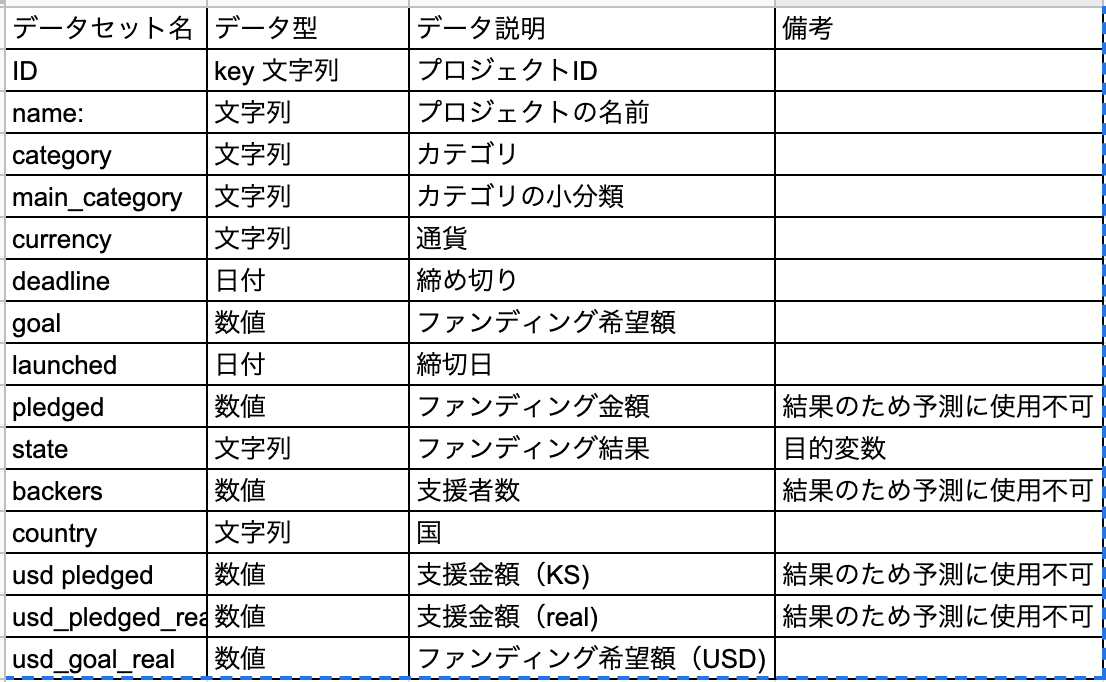

In [2]:
from IPython.display import Image
Image("./datadesc.png")

## 2.データのインポート

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler #データの標準化
from sklearn.model_selection import KFold #交差検証
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import SGDClassifier, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

df = pd.read_csv("./ks-projects-201801.csv",parse_dates=['deadline', 'launched'])


In [4]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
##データ中身の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null datetime64[ns]
goal                378661 non-null float64
launched            378661 non-null datetime64[ns]
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(2), object(6)
memory usage: 43.3+ MB


## 3予測用データとするための加工(前処理）

## 3.1予測に使えないデータの削除
ファンディング後に結果がわかるpledged,backers,usd pledged,usd_pledged_realをデータセットから削除する
 また目標金額を表すgoalはusd_goal_realを使用する。

In [6]:
df2 = df.drop(columns= ['goal','pledged', 'backers', 'usd pledged', 'usd_pledged_real'])

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 10 columns):
ID               378661 non-null int64
name             378657 non-null object
category         378661 non-null object
main_category    378661 non-null object
currency         378661 non-null object
deadline         378661 non-null datetime64[ns]
launched         378661 non-null datetime64[ns]
state            378661 non-null object
country          378661 non-null object
usd_goal_real    378661 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 28.9+ MB


## 3.2予測に使えないデータの削除
欠損値を確認し、欠損値への対応を実施する。

In [8]:
df2.isnull().sum()

ID               0
name             4
category         0
main_category    0
currency         0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

In [9]:
df2[df2['name'].isnull()]

,ID,name,category,main_category,currency,deadline,launched,state,country,usd_goal_real
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,2012-01-01 12:35:31,failed,US,200000.00
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2012-12-19 23:57:48,failed,GB,3224.97
309991,648853978,NaN,Product Design,Design,USD,2016-07-18,2016-06-18 05:01:47,suspended,US,2500.00
338931,796533179,NaN,Painting,Art,USD,2011-12-05,2011-11-06 23:55:55,failed,US,35000.00


In [10]:
#name以外のデータは入力されているが、数も少ないことからnameがnullのデータを削除する
df3 = df2.dropna()

In [11]:
df3.isnull().sum()

ID               0
name             0
category         0
main_category    0
currency         0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

## 3.3目的変数の加工
目的変数[state]の中身を確認し、分類に加工できるように加工する。

In [12]:
df3["state"].value_counts()

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

「undefinedは不明」、「liveは現在も募集中」であるため予測に使わないほうが良いと思料するため、削除。
canceledとsuspendはデータセットから外して良いかをデータの中身を見て確認してみる。

In [13]:
df[df['state']=="canceled"]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00
68,1000256760,"Raise the Woof, expanding the love (Canceled)",Design,Design,CAD,2015-08-07,15000.0,2015-07-08 21:46:53,700.00,canceled,6,CA,553.32,535.09,11466.14
70,1000260691,Gizbee™ Unlimited Removable Storage for Your T...,Gadgets,Technology,USD,2016-03-25,87000.0,2016-02-29 20:30:27,2030.00,canceled,15,US,2030.00,2030.00,87000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378640,999893629,Ciridian Helix (Canceled),Fiction,Publishing,USD,2014-09-11,1000.0,2014-08-08 21:49:31,100.00,canceled,2,US,100.00,100.00,1000.00
378643,999931480,Google Glass Shield (Canceled),3D Printing,Technology,USD,2014-05-26,6500.0,2014-05-05 20:22:45,0.00,canceled,0,US,0.00,0.00,6500.00
378648,999955533,Cards and Chit Network Season 2! (Canceled),Tabletop Games,Games,USD,2016-02-23,500.0,2016-01-24 16:03:27,121.00,canceled,5,US,121.00,121.00,500.00
378655,999976312,Angela's Poetry (Canceled),Poetry,Publishing,CAD,2014-09-20,5500.0,2014-08-06 03:46:07,0.00,canceled,0,CA,0.00,0.00,4949.60


In [14]:
df[df['state']=="suspended"]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
374,1001732009,DotPen : Redefines drawing and writing for sma...,Product Design,Design,USD,2014-08-09,25000.0,2014-06-30 21:17:10,39693.00,suspended,647,US,39693.00,39693.00,25000.00
688,1003367610,Aleppo - Make Soap Not War,Crafts,Crafts,DKK,2017-07-13,55000.0,2017-06-19 08:34:15,20320.00,suspended,60,DK,3059.73,3119.10,8442.45
689,1003378025,Hackchain - The World's First Wearable Wifi Ja...,Wearables,Technology,USD,2017-11-10,30000.0,2017-10-11 03:53:25,994.00,suspended,15,US,557.00,994.00,30000.00
1047,100524873,PRESIDENT OF THE UNITED STATES (Suspended),Academic,Publishing,USD,2015-10-25,5500.0,2015-08-26 05:54:42,0.00,suspended,0,US,0.00,0.00,5500.00
1114,1005618996,Masters of the Tooniverse Podcast (Suspended),Webseries,Film & Video,USD,2013-07-02,3200.0,2013-05-30 19:24:22,3226.00,suspended,24,US,3226.00,3226.00,3200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377481,994137973,UsBidi - The World's Most Intelligent Charger ...,Gadgets,Technology,AUD,2015-12-04,35000.0,2015-10-20 15:33:54,501964.79,suspended,8180,AU,365230.79,367309.23,25611.01
377485,994145334,Lego super hero cake (Suspended),Events,Food,USD,2015-09-28,100.0,2015-08-30 22:37:59,0.00,suspended,0,US,0.00,0.00,100.00
378423,998830045,Transgender MTF. Transition and the release of...,Journalism,Journalism,CAD,2015-07-14,30000.0,2015-05-15 21:40:02,5.00,suspended,1,CA,4.18,3.85,23116.04
378505,999198092,nanana (Suspended),Food,Food,USD,2015-08-07,1200.0,2015-07-08 22:41:49,13.00,suspended,1,US,13.00,13.00,1200.00


canceledもsuspendedもファンディング希望額に到底届かないのでcancel・suspendしていそうならばfailedに含めようと考えたが、データからでは
理由がはっきりせず、failedに含めた場合は恣意的なデータになる可能性があるので一旦データセットから削除することにする。

In [15]:
df4=(df3[df3['state'].isin(['failed', 'successful'])])

In [16]:
df4.head()

,ID,name,category,main_category,currency,deadline,launched,state,country,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,2016-02-26 13:38:27,successful,US,50000.00


In [17]:
#目的変数の2値変数化
df4["state"] = df4["state"] == "successful" # successful=>True, failed=>False
df4["state"].value_counts()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


False    197716
True     133956
Name: state, dtype: int64

## 4.分析前の可視化で傾向/前処理をする

4.1カテゴリー別の傾向

In [18]:
df4["category"].value_counts()

Product Design     18680
Documentary        14523
Music              12633
Tabletop Games     11744
Shorts             11394
                   ...  
Residencies           68
Letterpress           46
Chiptune              33
Literary Spaces       19
Taxidermy             10
Name: category, Length: 159, dtype: int64

In [19]:
df4["main_category"].value_counts()

Film & Video    56526
Music           45949
Publishing      35445
Games           28520
Technology      27050
Art             25640
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

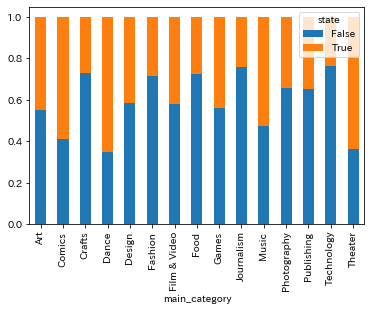

In [20]:
#main_category別に失敗成功比率をプロット
maincategory_state = pd.crosstab(df4["main_category"], df4["state"], normalize="index")
maincategory_state.plot.bar(stacked=True)
plt.show()

カテゴリ毎に成功率に違いがあり、説明変数として使えそう

4.2 国別の傾向

In [21]:
df4["country"].value_counts()

US      261358
GB       29453
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

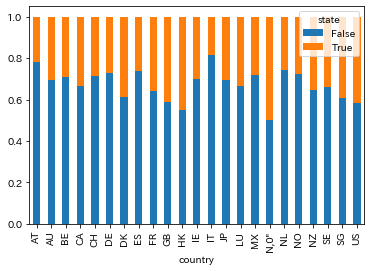

In [22]:
#main_category別に失敗成功比率をプロット
maincategory_state = pd.crosstab(df4["country"], df4["state"], normalize="index")
maincategory_state.plot.bar(stacked=True)
plt.show()

4.3 金額別の可視化

In [23]:
df4.loc[:,"usd_goal_real"].describe()

count    3.316720e+05
mean     4.150966e+04
std      1.108935e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

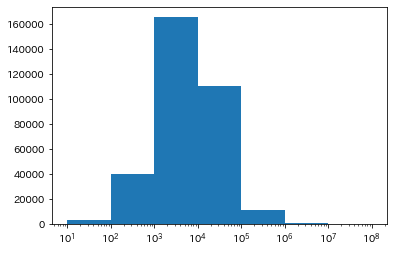

In [24]:
plt.hist(df4["usd_goal_real"], bins=np.logspace(1, 8, 8))
plt.gca().set_xscale("log")
plt.show()

金額を対数表現すると正規分布らしい感じなっているので変数も対数化する

In [25]:
df4['log_usd_goal_real'] = np.log(df4['usd_goal_real'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


4.4募集期間
launchからdeadlineまでの日付も成功するかどうかに関わるため、傾向を確認する

In [26]:
from datetime import datetime as dt
df4['days'] = (df4['deadline'] - df4['launched']).dt.days

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
df4['days'].head()

0    58
1    59
2    44
3    29
5    34
Name: days, dtype: int64

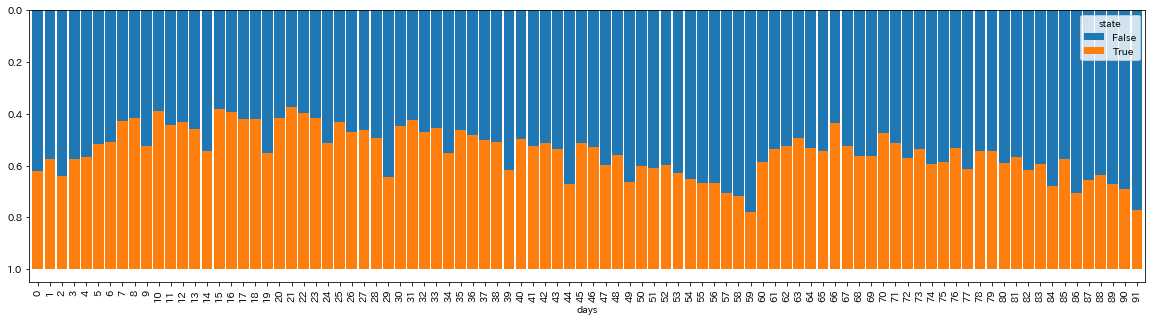

In [28]:
df_result = pd.crosstab(index=df4['days'], columns=df4['state'], normalize='index')
df_result.plot.bar(width=0.9, stacked=True, figsize=(20, 5))

plt.gca().invert_yaxis()
plt.show()

In [29]:
df4["days"].value_counts()

29    148478
59     27969
44     15241
30     11724
34      8619
       ...  
81        46
76        45
73        43
78        35
91        22
Name: days, Length: 92, dtype: int64

In [30]:
#日付も有効そうな変数のため利用することとする

4.5 nameのワード数

nameの単語数（短い過ぎても長過ぎてもどういうプロジェクトかわからない？）も成功か失敗に大きな影響を与えていると思われるので単語数での成功失敗を見てみる

In [31]:
df4["words"] = df4["name"].str.len()
df4.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ID,name,category,main_category,currency,deadline,launched,state,country,usd_goal_real,log_usd_goal_real,days,words
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,False,GB,1533.95,7.335601,58,31
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,False,US,30000.00,10.308953,59,45
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,False,US,45000.00,10.714418,44,14
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,False,US,5000.00,8.517193,29,49
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,2016-02-26 13:38:27,True,US,50000.00,10.819778,34,20


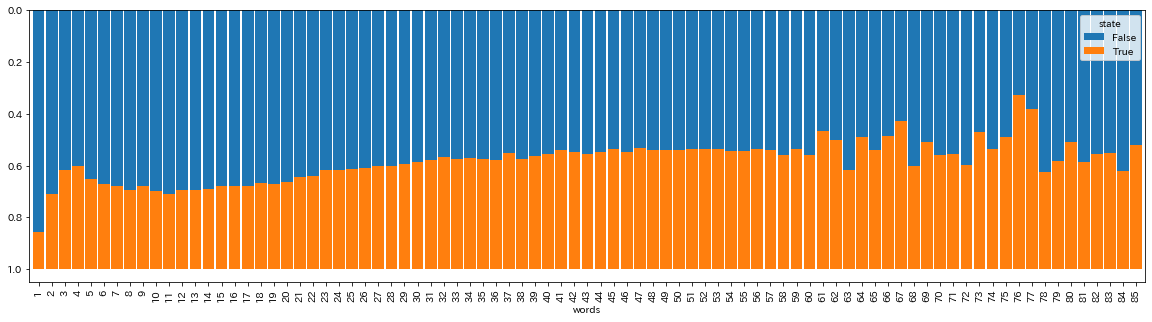

In [32]:
df_result = pd.crosstab(index=df4['words'], columns=df4['state'], normalize='index')
df_result.plot.bar(width=0.9, stacked=True, figsize=(20, 5))

plt.gca().invert_yaxis()
plt.show()

In [33]:
df4["words"].value_counts()

60    11331
59     8330
58     7312
20     7201
21     6985
      ...  
64       51
76       49
77       47
2        38
1         7
Name: words, Length: 85, dtype: int64

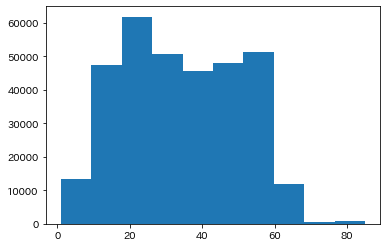

In [34]:
plt.hist(df4["words"])
plt.show()

文字数も何かしら影響がありそうなので使えそう

## 説明変数として使用する変数
category\main_category\country\ usd_goal_real\ days\ words

## 5.ダミー変数化相関係数の確認,モデル用のデータセット作成

In [35]:
df_model = pd.get_dummies(df4, columns=['main_category', 'category', 'country'], prefix=['mc', 'ca', 'co'])

In [36]:
df_model.info

<bound method DataFrame.info of                 ID                                               name  \
0       1000002330                    The Songs of Adelaide & Abullah   
1       1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2       1000004038                                     Where is Hank?   
3       1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
5       1000014025                               Monarch Espresso Bar   
...            ...                                                ...   
378654   999975836              Homemade fresh dog food, Cleveland OH   
378657   999977640                                          The Tribe   
378658   999986353  Walls of Remedy- New lesbian Romantic Comedy f...   
378659   999987933                           BioDefense Education Kit   
378660   999988282                  Nou Renmen Ayiti!  We Love Haiti!   

       currency   deadline            launched  state  usd_goal_real  \
0           GBP 201

In [37]:
feature = df_model.drop(['usd_goal_real','ID', 'currency','state','name', 'deadline','launched' ], axis=1).columns.values
X = df_model[feature].values
y = df_model['state'].values

訓練データとテストデータに分ける
訓練:テスト＝８：２

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

## 6.特徴選択
lasso　CVで特徴選択

In [39]:
estimator = LassoCV(cv=5, random_state=1234)

sfm = SelectFromModel(estimator)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001,
                                  fit_intercept=True, max_iter=1000,
                                  n_alphas=100, n_jobs=None, normalize=False,
                                  positive=False, precompute='auto',
                                  random_state=1234, selection='cyclic',
                                  tol=0.0001, verbose=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

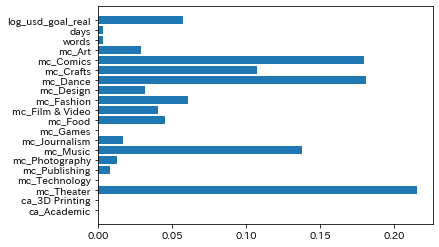

In [40]:

column_size = 20

abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef = abs_coef[:column_size]
plt.barh(np.arange(0, column_size), abs_coef, tick_label=feature[:column_size])
plt.gca().invert_yaxis() # y軸反転
plt.show()

In [41]:
new_feature = sfm.get_support()
# 先頭2つの「days」「log_usd_goal_real」「words」は削除しないようにガードしておく
new_feature[:3] = True

print('Feature: {}->{}'.format(len(new_feature), np.sum(new_feature)))

X_train = X_train[:, new_feature]
X_test = X_test[:, new_feature]

Feature: 200->42


## 6.学習の準備

## 7.モデルの実施
ロジスティック回帰・決定木・ランダムフォレストでモデルを作成し、一番精度がいいものをさらに掘り下げる
（すべて一旦k-fold5で実施）

In [42]:
##精度比較用
df_precision = pd.DataFrame(index=['訓練','テスト'])
display(df_precision)

""
訓練
テスト


7-1 決定木

In [43]:
from sklearn.tree import export_graphviz
clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_leaf=3, random_state=1234)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_pred)

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print("訓練accuracy=",train_acc,"テストaccuracy=",test_acc)
#精度格納
df_precision['決定木'] = [round(train_acc,3),round(test_acc,3)]
df_precision

訓練accuracy= 0.8285237264309162 テストaccuracy= 0.6202004974749378


,決定木
訓練,0.829
テスト,0.620


7.2ランダムフォレスト

In [44]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None, criterion="gini",
                                                 min_samples_leaf=3, random_state=1234)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_pred)

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("訓練accuracy=",train_acc,"テストaccuracy=",test_acc)
#精度格納
df_precision['RF'] = [round(train_acc,3),round(test_acc,3)]
df_precision

訓練accuracy= 0.8023683089806548 テストaccuracy= 0.6595613175548353


,決定木,RF
訓練,0.829,0.802
テスト,0.620,0.660


7.３アダブースト

In [45]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_pred)

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("訓練accuracy=",train_acc,"テストaccuracy=",test_acc)
#精度格納
df_precision['AB'] = [round(train_acc,3),round(test_acc,3)]
df_precision


訓練accuracy= 0.6745534923512364 テストaccuracy= 0.672767015904123


,決定木,RF,AB
訓練,0.829,0.802,0.675
テスト,0.620,0.660,0.673


7-４. Bagging

In [46]:
clf = BaggingClassifier(DecisionTreeClassifier(max_depth=3,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_pred)

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("訓練accuracy=",train_acc,"テストaccuracy=",test_acc)
#精度格納
df_precision['Bagging'] = [round(train_acc,3),round(test_acc,3)]
df_precision


訓練accuracy= 0.6210517191345346 テストaccuracy= 0.6185573226803347


,決定木,RF,AB,Bagging
訓練,0.829,0.802,0.675,0.621
テスト,0.620,0.660,0.673,0.619


7.５ SDG

In [47]:
clf = SGDClassifier(loss='log', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_pred)

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("訓練accuracy=",train_acc,"テストaccuracy=",test_acc)
#精度格納
df_precision['SDG'] = [round(train_acc,3),round(test_acc,3)]
df_precision

訓練accuracy= 0.5359071671120123 テストaccuracy= 0.5351021331122333


,決定木,RF,AB,Bagging,SDG
訓練,0.829,0.802,0.675,0.621,0.536
テスト,0.620,0.660,0.673,0.619,0.535


決定木・RFで過学習が発生している。一度ハイパーパラメータを全てモデルで探索してみて、過学習が発生するかを確認する

## 8. ハイパーパラメータ調整

In [48]:
def get_best_estimator(clf, param, label):
    clf_rand = RandomizedSearchCV(estimator=clf, param_distributions=param, cv=3, n_iter=25, return_train_score=True)
    clf_rand.fit(X_train[:10000], y_train[:10000])   

    print('{}'.format(label))
    print('Best Parameters: {}'.format(clf_rand.best_params_))
    print('Accuracy: {:.3f}'.format(clf_rand.best_score_))
    print('')
    
    return clf_rand.best_estimator_

In [49]:
param_decision_tree = {
        'min_samples_split': [2, 10, 20, 100],
        'min_samples_leaf': [1, 10, 20, 100],
        'max_leaf_nodes': [None, 100, 1000],
        'max_depth': [None, 10, 20]}

param_random_forest = {
        'n_estimators': [10, 20, 50, 100],
        'min_samples_split': [2, 10, 100],
        'min_samples_leaf': [1, 10, 100],
        'max_leaf_nodes': [None, 100, 1000],
        'max_depth': [None, 10, 20]}

param_adaboost = {
        'n_estimators': [10, 20, 50, 100],
        'base_estimator__min_samples_split': [2, 10, 100],
        'base_estimator__min_samples_leaf': [1, 10, 100],
        'base_estimator__max_leaf_nodes': [None, 100, 1000],
        'base_estimator__max_depth': [None, 10, 20]}

param_bagging = {
        'n_estimators': [10, 20, 50, 100], 
        'base_estimator__min_samples_split': [2, 10, 100],
        'base_estimator__min_samples_leaf': [1, 10, 100],
        'base_estimator__max_leaf_nodes': [None, 100, 1000],
        'base_estimator__max_depth': [None, 10, 20]}

In [50]:
clf_sgd = SGDClassifier(loss='log', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf_decision_tree = DecisionTreeClassifier(criterion='gini', random_state=1234)
clf_random_forest = RandomForestClassifier(criterion='gini', random_state=1234)

decision_tree = DecisionTreeClassifier(criterion='gini', random_state=1234)
clf_adaboost = AdaBoostClassifier(base_estimator=decision_tree, random_state=1234)
clf_bagging = BaggingClassifier(base_estimator=decision_tree, random_state=1234)

In [51]:
clf_decision_tree = get_best_estimator(clf_decision_tree, param_decision_tree, 'Decision Tree')
clf_random_forest = get_best_estimator(clf_random_forest, param_random_forest, 'Random Forest')
clf_adaboost = get_best_estimator(clf_adaboost, param_adaboost, 'AdaBoost + Decision Tree')
clf_bagging = get_best_estimator(clf_bagging, param_bagging, 'Bagging + Decision Tree')

Decision Tree
Best Parameters: {'min_samples_split': 100, 'min_samples_leaf': 10, 'max_leaf_nodes': 1000, 'max_depth': 10}
Accuracy: 0.651

Random Forest
Best Parameters: {'n_estimators': 50, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_leaf_nodes': 1000, 'max_depth': 20}
Accuracy: 0.677

AdaBoost + Decision Tree
Best Parameters: {'n_estimators': 10, 'base_estimator__min_samples_split': 10, 'base_estimator__min_samples_leaf': 100, 'base_estimator__max_leaf_nodes': 100, 'base_estimator__max_depth': 10}
Accuracy: 0.652

Bagging + Decision Tree
Best Parameters: {'n_estimators': 100, 'base_estimator__min_samples_split': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__max_leaf_nodes': 100, 'base_estimator__max_depth': 20}
Accuracy: 0.670



上記の最適なパラメータでモデルを実装してみて汎化誤差をみてみる

In [52]:
##パラメータ精度比較用
df_precision_after = pd.DataFrame(index=['訓練','テスト'])
display(df_precision_after)

""
訓練
テスト


In [53]:
from sklearn.tree import export_graphviz
clf = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_split=100 ,min_samples_leaf=1,random_state=1234)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_pred)

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print("訓練accuracy=",train_acc,"テストaccuracy=",test_acc)
#精度格納
df_precision_after['決定木'] = [round(train_acc,3),round(test_acc,3)]
df_precision_after

訓練accuracy= 0.6686704078209974 テストaccuracy= 0.6617622672797165


,決定木
訓練,0.669
テスト,0.662


In [54]:
clf = RandomForestClassifier(n_estimators=50, max_depth=None, criterion="gini",
                                                 min_samples_leaf=10, min_samples_split=10,max_leaf_nodes=None,random_state=1234)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_pred)

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("訓練accuracy=",train_acc,"テストaccuracy=",test_acc)
#精度格納
df_precision_after['RF'] = [round(train_acc,3),round(test_acc,3)]
df_precision_after

訓練accuracy= 0.7319597342247783 テストaccuracy= 0.6800934649883169


,決定木,RF
訓練,0.669,0.732
テスト,0.662,0.680


In [55]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,
                                                                                 min_samples_leaf=100,
                                                                                 min_samples_split=100, 
                                                                                 random_state=1234,
                                                                                 criterion="gini",
                                                                                 max_leaf_nodes=100),
                                           n_estimators=10, random_state=1234)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_pred)

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("訓練accuracy=",train_acc,"テストaccuracy=",test_acc)
#精度格納
df_precision_after['AB'] = [round(train_acc,3),round(test_acc,3)]
df_precision_after


訓練accuracy= 0.690152523017898 テストaccuracy= 0.6793698650787668


,決定木,RF,AB
訓練,0.669,0.732,0.690
テスト,0.662,0.680,0.679


In [56]:
clf = BaggingClassifier(DecisionTreeClassifier(max_depth=20,
                                                                                 min_samples_leaf=1,
                                                                                 min_samples_split=100, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=100, random_state=1234)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_pred)
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("訓練accuracy=",train_acc,"テストaccuracy=",test_acc)
#精度格納
df_precision_after['Bagging'] = [round(train_acc,3),round(test_acc,3)]
df_precision_after


訓練accuracy= 0.7112690653772372 テストaccuracy= 0.6815105148111856


,決定木,RF,AB,Bagging
訓練,0.669,0.732,0.690,0.711
テスト,0.662,0.680,0.679,0.682


汎化誤差はなくなったが、精度が低くなっている。

## ニューラルネットワークでやってみる

In [58]:
from tensorflow.keras.utils import to_categorical
y_train_ca = to_categorical(y_train)
y_test_ca = to_categorical(y_test)

print("X_train=",X_train)
print()
print("X_test=",X_test)
print()
print("y_train=",y_train_ca)
print()
print("y_test=",y_test_ca)

X_train= [[10.59663473 39.         59.         ...  0.          0.
   1.        ]
 [ 6.90775528 29.         18.         ...  0.          0.
   1.        ]
 [ 4.6726419  29.         35.         ...  0.          0.
   0.        ]
 ...
 [ 7.46737107 29.         52.         ...  0.          0.
   1.        ]
 [ 7.76254501 36.         46.         ...  0.          1.
   0.        ]
 [ 9.90348755 29.         30.         ...  0.          0.
   1.        ]]

X_test= [[13.21785058 33.         52.         ...  0.          0.
   0.        ]
 [ 8.51719319  8.          4.         ...  0.          0.
   1.        ]
 [ 7.82404601 18.         33.         ...  0.          0.
   1.        ]
 ...
 [ 8.69951475 38.         58.         ...  0.          0.
   1.        ]
 [ 6.62007321 16.         51.         ...  0.          0.
   1.        ]
 [ 9.6485953  29.         18.         ...  0.          0.
   1.        ]]

y_train= [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]

y_test= [[0. 1.]
 [1. 0

In [61]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=42))
model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(3, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [62]:
# 計算の実行
fit = model.fit(X_train, y_train_ca,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test_ca))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)


ValueError: A target array with shape (265337, 2) was passed for an output of shape (None, 3) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.

## 9.まとめ

70%よりそれ以上の精度が出ないので他にどうすればいいかアドバイスいただきたい

ニューラルネットワークがエラーを起こすので対処法を知りたい